## Install Packages

In [1]:
!conda install -y -c conda-forge faiss-gpu
!apt-get -y update
!apt-get -y install libatlas-base-dev

done
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.8.0.*, but conda is ignoring the .* and treating it as 1.8.0
WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.6.0.*, but conda is ignoring the .* and treating it as 1.6.0
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - faiss-gpu


The followin

## Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.random_projection import GaussianRandomProjection

from tqdm import tqdm

import faiss

In [3]:
df = pd.read_csv("../story_dataset.csv")
df

,prompt_id,prompt,story,hidden_state_file,len_generated_story,len_new_story
0,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Blaz...,./hidden_states/prompt_1.npz,270,271
1,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Spar...,./hidden_states/prompt_1.npz,349,350
2,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Scor...,./hidden_states/prompt_1.npz,278,278
3,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,117,118
4,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,129,130
...,...,...,...,...,...,...
9995,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,289,290
9996,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,119,119
9997,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,127,128
9998,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,441,441


In [4]:
max_story_len = max(df["len_generated_story"])
max_story_len

522

In [5]:
hidden_states_by_layer = {}
NUM_PROMPTS = 10

for prompt_id in range(1, NUM_PROMPTS + 1):
    with np.load(f'../hidden_states/prompt_{prompt_id}.npz') as loaded_data:
        for i in tqdm(range(1000)):
            curr_hidden_states = loaded_data[f"arr_{i}"][0]
#             print(curr_hidden_states.shape)
            for layer in range(4, 5):
                padded_arr = np.zeros((max_story_len, 512))
                padded_arr_len = len(curr_hidden_states[layer][0])
                
                padded_arr[:padded_arr_len] = curr_hidden_states[layer][0]
                
                padded_arr = padded_arr.flatten().astype('float32') #FAISS expects data in type float32 instead of float64 - saves memory too!
#                 print(padded_arr.shape)
                
                if(f"layer_{layer}" in hidden_states_by_layer):
                    hidden_states_by_layer[f"layer_{layer}"].append(padded_arr)
                else:
                    hidden_states_by_layer[f"layer_{layer}"] = [padded_arr]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:31<00:00, 10.96it/s]


In [6]:
layer_hs_array = np.array(hidden_states_by_layer["layer_4"])
layer_hs_array.shape

(10000, 267264)

## Layer 4 Clustering

In [7]:
# Use original vectors for clustering - uncomment next line and comment out last two lines

# dim_reduced_vecs = layer_hs_array

random_projector = GaussianRandomProjection(random_state = 42)
dim_reduced_vecs = random_projector.fit_transform(layer_hs_array).astype('float32')

In [8]:
dim_reduced_vecs = np.array([v / np.linalg.norm(v) for v in dim_reduced_vecs])
dim_reduced_vecs.shape

(10000, 7894)

In [9]:
prompt_ids = df["prompt_id"]
prompt_ids = prompt_ids.to_numpy()
prompt_ids

array([ 1,  1,  1, ..., 10, 10, 10])

In [10]:
X_train = np.zeros((int(0.8 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_train = np.zeros(int(0.8 * dim_reduced_vecs.shape[0]))

X_test = np.zeros((int(0.2 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_test = np.zeros(int(0.2 * dim_reduced_vecs.shape[0]))

In [11]:
for i in range(10):
    X_train[i * 800 : (i + 1) * 800] = dim_reduced_vecs[i * 1000 : (i * 1000) + 800]
    y_train[i * 800 : (i + 1) * 800] = prompt_ids[i * 1000 : (i * 1000) + 800]
    
    X_test[i * 200 : (i + 1) * 200] = dim_reduced_vecs[(i * 1000) + 800 : (i + 1) * 1000]
    y_test[i * 200 : (i + 1) * 200] = prompt_ids[(i * 1000) + 800 : (i + 1) * 1000]

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 7894)
(8000,)
(2000, 7894)
(2000,)


Sampling a subset of 4000 / 8000 for training
Clustering 4000 points in 7894D to 5 clusters, redo 10 times, 20 iterations
  Preprocessing in 0.10 s
Outer iteration 0 / 10
  Iteration 19 (0.53 s, search 0.28 s): objective=1924.73 imbalance=1.106 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (1.05 s, search 0.54 s): objective=1917.28 imbalance=1.133 nsplit=0       
Outer iteration 2 / 10
  Iteration 19 (1.56 s, search 0.81 s): objective=1919.37 imbalance=1.069 nsplit=0       
Outer iteration 3 / 10
  Iteration 19 (2.08 s, search 1.08 s): objective=1923.48 imbalance=1.093 nsplit=0       
Outer iteration 4 / 10
  Iteration 19 (2.59 s, search 1.34 s): objective=1916.7 imbalance=1.139 nsplit=0        
Outer iteration 5 / 10
  Iteration 19 (3.11 s, search 1.61 s): objective=1924.1 imbalance=1.102 nsplit=0        
Outer iteration 6 / 10
  Iteration 19 (3.62 s, search 1.87 s): objective=1909.74 imbalance=1.693 nsplit=0       
Outer iteration 7 / 10


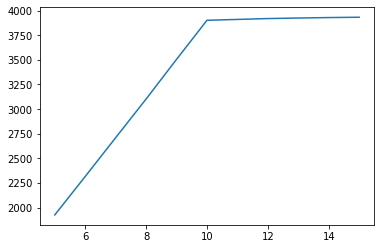

In [13]:
# Elbow Plot
niter = 20
verbose = True
dim = X_train.shape[1]

k_vals = [k for k in range(5, 16)]
wccs = []
for k in k_vals:
    kmeans = faiss.Kmeans(dim, k, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
    kmeans.train(X_train)
    wccs.append(kmeans.obj[-1])

plt.plot(k_vals, wccs)

In [14]:
# K-means Clustering

# ncentroids = NUM_PROMPTS
ncentroids = 10 # Elbow point - based on objective (sum of cosine similarities)
niter = 20
verbose = True
dim = X_train.shape[1]
kmeans = faiss.Kmeans(dim, ncentroids, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
kmeans.train(X_train)


Clustering 8000 points in 7894D to 10 clusters, redo 10 times, 20 iterations
  Preprocessing in 0.04 s
Outer iteration 0 / 10
  Iteration 19 (1.02 s, search 0.53 s): objective=3886.47 imbalance=1.415 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (2.06 s, search 1.05 s): objective=3892.43 imbalance=1.253 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (3.10 s, search 1.58 s): objective=3885.26 imbalance=1.206 nsplit=0       
Outer iteration 3 / 10
  Iteration 19 (4.14 s, search 2.10 s): objective=3895.22 imbalance=1.213 nsplit=0       
Objective improved: keep new clusters
Outer iteration 4 / 10
  Iteration 19 (5.16 s, search 2.63 s): objective=3867 imbalance=2.167 nsplit=0          
Outer iteration 5 / 10
  Iteration 19 (6.20 s, search 3.16 s): objective=3899.8 imbalance=1.123 nsplit=0        
Objective improved: keep new clusters
Outer iteration 6 / 10
  Iteration 19 (7.24 s, search 3.69 s): obj

3901.668212890625

In [15]:
kmeans.centroids #cluster centers

array([[ 0.01128962, -0.01053565,  0.01145754, ..., -0.0148626 ,
         0.00863794,  0.00055422],
       [ 0.01004875, -0.00930905,  0.01186136, ..., -0.00664355,
         0.00591346,  0.01189429],
       [ 0.01490633, -0.00631898,  0.01133053, ..., -0.00870484,
         0.00463008,  0.00412625],
       ...,
       [ 0.01640298, -0.01224543,  0.01251834, ..., -0.01069688,
         0.00414848,  0.00312975],
       [ 0.01064859, -0.00728876,  0.01092339, ..., -0.01305846,
         0.00762394,  0.0038474 ],
       [ 0.01330592,  0.00107891,  0.01666225, ..., -0.00790137,
         0.01213517,  0.00216218]], dtype=float32)

In [16]:
for centroid in kmeans.centroids:
    print(np.linalg.norm(centroid))

1.0000002
1.0
0.99999964
0.99999976
1.0000002
1.0
0.9999998
1.0
1.0000001
1.0000001


In [17]:
kmeans.obj #inertia at each iteration

array([2456.9543457 , 3730.6105957 , 3813.15551758, 3847.00561523,
       3860.83764648, 3869.31665039, 3874.24169922, 3878.17041016,
       3882.6340332 , 3884.69067383, 3885.88330078, 3886.26977539,
       3886.39086914, 3886.43041992, 3886.44555664, 3886.45874023,
       3886.46826172, 3886.47265625, 3886.47143555, 3886.47265625,
       2477.47680664, 3741.82788086, 3794.07128906, 3842.62304688,
       3865.50048828, 3879.07373047, 3885.30029297, 3887.31884766,
       3888.14379883, 3888.609375  , 3888.83618164, 3889.046875  ,
       3889.2487793 , 3889.52539062, 3889.90844727, 3890.33740234,
       3890.90380859, 3891.7800293 , 3892.28369141, 3892.43286133,
       2383.18969727, 3733.93823242, 3804.35546875, 3835.99169922,
       3846.85961914, 3853.29956055, 3857.92993164, 3860.92529297,
       3864.20166016, 3867.34887695, 3869.19360352, 3871.12695312,
       3873.55541992, 3875.58764648, 3877.3425293 , 3879.32763672,
       3882.17431641, 3884.48120117, 3885.12548828, 3885.26147

In [18]:
cos_similarities = X_train @ kmeans.centroids.T
classifications_train = np.argmax(cos_similarities, axis=1)

In [19]:
pd.Series(classifications_train).value_counts()

4    1084
7    1064
1    1032
5     991
3     919
8     762
2     722
0     600
9     455
6     371
dtype: int64

In [20]:
# Get most common label for each point classified to a centroid (same centroid)
centroid_labels = [np.where(classifications_train == i)[0] for i in range(ncentroids)]
max_label_per_centroid = [int(pd.Series(y_train[centroid_labels[i]]).value_counts().idxmax()) for i in range(ncentroids)]
max_label_per_centroid

[5, 1, 10, 5, 7, 6, 10, 6, 5, 3]

In [21]:
centroid_to_label = {idx : max_label_per_centroid[idx] for idx in range(len(max_label_per_centroid))}

In [22]:
centroid_to_label

{0: 5, 1: 1, 2: 10, 3: 5, 4: 7, 5: 6, 6: 10, 7: 6, 8: 5, 9: 3}

In [23]:
vectorized_map = np.vectorize(centroid_to_label.get)
classifications_to_label = vectorized_map(classifications_train)

classifications_to_label

array([ 5,  6,  6, ..., 10, 10, 10])

In [24]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label[i * 800:(i + 1) * 800] == (i + 1)))

Prompt 1 Accuracy:  0.295
Prompt 2 Accuracy:  0.0
Prompt 3 Accuracy:  0.56625
Prompt 4 Accuracy:  0.0
Prompt 5 Accuracy:  0.95
Prompt 6 Accuracy:  0.52125
Prompt 7 Accuracy:  0.28625
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.0
Prompt 10 Accuracy:  0.9475


In [25]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label == y_train))

Overall Accuracy:  0.356625


## Perform Inference on Test Set & Collect Test Accuracy

In [26]:
cos_similarities = X_test @ kmeans.centroids.T
classifications_test = np.argmax(cos_similarities, axis=1)

In [27]:
pd.Series(classifications_test).value_counts()

1    273
4    272
7    271
5    242
3    233
2    189
8    172
0    151
9    113
6     84
dtype: int64

In [28]:
classifications_to_label_test = vectorized_map(classifications_test)

classifications_to_label_test

array([ 1, 10,  5, ..., 10, 10, 10])

In [29]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label_test[i * 200:(i + 1) * 200] == (i + 1)))

Prompt 1 Accuracy:  0.31
Prompt 2 Accuracy:  0.0
Prompt 3 Accuracy:  0.56
Prompt 4 Accuracy:  0.0
Prompt 5 Accuracy:  0.95
Prompt 6 Accuracy:  0.505
Prompt 7 Accuracy:  0.345
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.0
Prompt 10 Accuracy:  0.97


In [30]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label_test == y_test))

Overall Accuracy:  0.364


## Confusion Matrix of Results

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

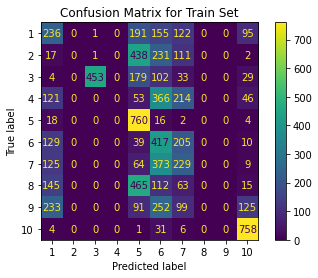

In [32]:
cm = confusion_matrix(y_train, classifications_to_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Train Set')
plt.show()

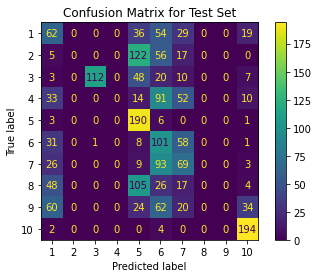

In [33]:
cm = confusion_matrix(y_test, classifications_to_label_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Test Set')
plt.show()